In [1]:
import os
import numpy as np
import pandas as pd
import copy
import h5py

from scipy.spatial.distance import pdist, squareform, cosine, correlation
from scipy.linalg import block_diag
from scipy.stats import kendalltau

import pickle
import sys
PATH_TO_CODE = '../code/'
sys.path.append(os.path.abspath(PATH_TO_CODE))
from kinematics_decoding import load_model

import matplotlib.pyplot as plt
import seaborn as sns


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



**Comparison to Oracle.**

In [ ]:
# Create Oracle RDM.
one_class = np.ones((200, 200))*2
all_classes = [one_class for _ in range(20)]
block_rdm_sqform = 2 - block_diag(*all_classes)
oracle_rdm = squareform(block_rdm_sqform)

In [ ]:
def sort_layers(layers_list, arch_type):
    if arch_type == 'temporal_spatial':
        return sorted(layers_list, key=lambda x: x.replace('s', 'x'))
    return sorted(layers_list)

In [ ]:
# Select Models to compare to ideal observer RDM
all_models = pickle.load(open('../nn-training/analyzed_convmodels.p', 'rb'))

# For each model, compute distance to Oracle RDM, initially just using Correlation Distance
# Save for each layer : model_name, layer_name, layer_number, layer_reldepth, distance_to_oracle, arch_type

layerwise_distances = []
for i in range(len(all_models)):
    mymodel = load_model(all_models.iloc[i], 4, 'conv', all_models['is_trained'].iloc[i])
    mymodel_rdms = pickle.load(open(os.path.join(mymodel.model_path, 'model_rdm.p'), 'rb'))

    # Sort layer names, numbers
    layers_list = copy.copy(list(mymodel_rdms.keys()))
    layers_list.remove('score')
    layers_list = sort_layers(layers_list, mymodel.arch_type)

    for j in range(len(layers_list)):
        mylayer_results = {'model_name': mymodel.name,
                           'arch_type': mymodel.arch_type,
                           'layer_name': layers_list[j],
                           'layer_number': j + 1,
                           'layer_reldep': (j+1)/(len(layers_list)),
                           'is_trained' : all_models['is_trained'].iloc[i]}
        mylayer_results['oracle_corr'] = correlation(oracle_rdm, mymodel_rdms[layers_list[j]])
        mylayer_results['oracle_kendall'], _ = kendalltau(oracle_rdm, mymodel_rdms[layers_list[j]])
        layerwise_distances.append(mylayer_results)
            
results = pd.DataFrame(copy.copy(layerwise_distances))

In [ ]:
# Get oracle correlation for spindle firing rate response representation
kinematics = pickle.load(open('./kinematics_rdms.p', 'rb'))

kinematics_distances = []

for key, val in kinematics.items():
    mykin_results = {'model_name': key,
                     'arch_type': 'kinematics',
                     'layer_name': None,
                     'layer_number': 0,
                     'layer_reldep': 0}
    mykin_results['oracle_corr'] = correlation(oracle_rdm, val)
    mykin_results['oracle_kendall'], _ = 0, 0
    kinematics_distances.append(mykin_results)
    
results_kinematcs = pd.DataFrame(copy.copy(kinematics_distances))

In [ ]:
results.to_pickle('analyzed_models_idealobs_rdm.p')
results_kinematcs.to_pickle('kinematics_idealobs_rdm.p')

**Plotting oracle comparison results.**

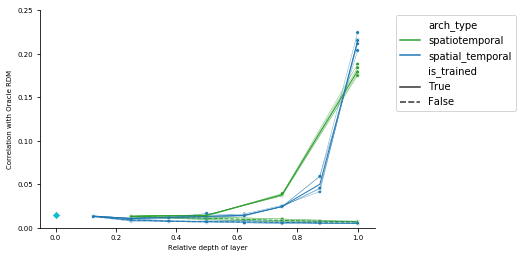

In [3]:
results_kinematics = pickle.load(open('./kinematics_idealobs_rdm.p', 'rb'))
results = pickle.load(open('./analyzed_models_idealobs_rdm.p', 'rb'))

# plt.figure(figsize=[3, 3])
sns.scatterplot(x='layer_reldep', y=1-results_kinematics.oracle_corr, 
                data=results_kinematics[results_kinematics['model_name'] == 'spindle_firing'],
                marker='D', color='C9')

sns.lineplot(x='layer_reldep', y=1-results.oracle_corr, hue='arch_type', style='is_trained',
             data=results, err_style=None, lw=1, style_order=[True, False],
             hue_order=['spatiotemporal', 'spatial_temporal'], palette=['C2', 'C0'])
sns.lineplot(x='layer_reldep', y=1-results.oracle_corr, hue='arch_type',
             data=results, estimator=None, lw=0.3, units='model_name',
             hue_order=['spatiotemporal', 'spatial_temporal'], palette=['C2', 'C0'], legend=None)

sns.scatterplot(x='layer_reldep', y=1-results.oracle_corr, hue='arch_type',
                data=results, legend=None, s=15, 
                hue_order=['spatiotemporal', 'spatial_temporal'], palette=['C2', 'C0'])

plt.ylabel('Correlation with Oracle RDM', fontsize=7)
plt.xlabel('Relative depth of layer', fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.ylim([0, 0.25])
sns.despine()

plt.legend(bbox_to_anchor=(1.05, 1), loc=2)